# Adam vs AMSGrad
This notebook aims to compare the optimizers Adam and AMSGrad. The goal is to synthetically create a situation in linear regression, using MSE as the loss function, where AMSGrad actually performs worse, on average, than Adam. This notebook uses base code found in a [TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/regression).

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Get Data
The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


In [243]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

### Data Cleaning

In [244]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')


### Split features from labels

In [245]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### The Normalization layer

In [246]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [247]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

## Find Preconditioned Data Matrix

In [248]:
print("Condition Number A: ", np.linalg.cond(train_features.T @ train_features))
print("Condition Number Normalized/Scaled Matrix: ", np.linalg.cond(np.array(normalizer(train_features)).T@np.array(normalizer(train_features))))

P = np.sqrt(np.linalg.inv(np.diag(np.diag(train_features.T @ train_features))))
conditioned_A = P@train_features.T@train_features@P

print("Condition Number Jacobi Preconditioner: ", np.linalg.cond(conditioned_A))

Condition Number A:  22944342128.68691
Condition Number Normalized/Scaled Matrix:  3200024.5
Condition Number Jacobi Preconditioner:  8850.328096071313


In [249]:
# Check Shapes of Preconditioned Matrix and Original Data Matrix
conditioned_A.shape, train_features.shape

((9, 9), (314, 9))

## Multivariate Linear Regression

In [250]:
linear_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1, amsgrad=True),
    loss='mse')

CPU times: user 9.83 s, sys: 152 ms, total: 9.99 s
Wall time: 9.86 s


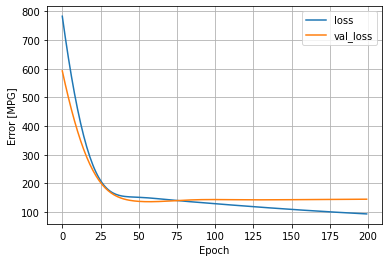

In [251]:
%%time
history = linear_model.fit(
    tf.convert_to_tensor(conditioned_A, dtype = tf.float32), tf.convert_to_tensor(train_labels, dtype = tf.float32), 
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

plot_loss(history)

## Create Functions for Iterative Function

In [252]:
def plot_loss_2(history1, history2):
  try:
    plt.plot(history1.history['loss'], label='adam train loss')
    plt.plot(history2.history['loss'], label='ams train loss')
  except:
    print("Break")
    pass
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.show()

In [253]:
def random_diag(dim, low, high):

  diagonal_entries = np.random.randint(low = low, high = high, size = dim)
  D = np.diag(diagonal_entries)

  return D

In [254]:
def random_matrix_cond(dim, cond):

  n=dim
  cond_P = cond
  try:
    log_cond_P = np.log(cond_P)
    exp_vec = np.arange(-log_cond_P/4., log_cond_P * (n + 1)/(4 * (n - 1)), log_cond_P/(2.*(n-1)))[:9]
    s = np.exp(exp_vec)
    S = np.diag(s)
    U, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
    V, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
    P = U.dot(S).dot(V.T)
    P = P.dot(P.T)
  except:
    P = conditioned_A
  return P


In [265]:
def random_diag_mat_2(num_iter, avg_iter, lr, epochs, patience, monitor, mat_func):
  mat_type = str(mat_func).split()[1]
  
  # Number of epochs with no improvement after which training will be stopped
  callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

  # Instantiate running lists
  total_history_adam = []
  total_history_ams = []
  total_epochs_for_convergence_adam = []
  total_epochs_for_convergence_ams = []
  for i in range(num_iter):
    # Pass Parameters based on mat_func passed
    if mat_type == 'random_diag':
      D = mat_func(dim=9, low=10, high=20)
    else:
      D = mat_func(dim=9, cond=(i+1)*10)
    # Draw a random diagonal matrix
    # D = rand_mat(dim=9, cond=(i+1)*10)
    # D = random_diag(dim=9, low=10, high=20)
    # Convert Data to Tensor
    data_input = tf.convert_to_tensor(D, dtype = tf.float32)

  
    print("------------ Iter: ", i, " ------------")
    print("\nCondition Number: ", round(np.linalg.cond(D),2))

    # Instantiate running lists
    avg_epochs_adam = 0
    avg_epochs_ams = 0
    batch_adam = []
    batch_ams = []
    for j in range(avg_iter):

        # Defining Linear Models for Adama and AMS and compiling
        # linear_model_adam = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
        linear_model_adam = tf.keras.Sequential([layers.Dense(units=1)])
        linear_model_adam.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss='mse')

        # linear_model_ams = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
        linear_model_ams = tf.keras.Sequential([layers.Dense(units=1)])
        linear_model_ams.compile(optimizer=tf.optimizers.Adam(learning_rate=lr, amsgrad=True), loss='mse')
        
        # Run Models
        history_adam = linear_model_adam.fit(
        data_input, train_labels, 
        epochs=epochs,
        verbose=0,
        validation_split = 0.2,
        callbacks=[callback])

        history_ams = linear_model_ams.fit(
        data_input, train_labels, 
        epochs=epochs,
        verbose=0,
        validation_split = 0.2,
        callbacks=[callback])

        # Printing number of epochs for convergence as defined by callback 
        print("-------")
        print("Run: ", j)
        print("Adam Epochs to Convergence: ",  len(history_adam.history['loss']))
        print("AMS Epochs to Convergence", len(history_ams.history['loss']))
        #c

        # Running total of number of epochs until convergence
        avg_epochs_adam += len(history_adam.history['loss'])
        avg_epochs_ams += len(history_ams.history['loss'])

        # Add TensorFlow history objects to running list
        batch_adam.append(history_adam)
        batch_ams.append(history_ams)

        # Plot
        plot_loss_2(history_adam, history_ams)

    total_epochs_for_convergence_adam.append(math.ceil(avg_epochs_adam / avg_iter))
    total_epochs_for_convergence_ams.append(math.ceil(avg_epochs_ams / avg_iter))

    print("-------")
    print("\nAdam AVG Epochs to Convergence: ", math.ceil(avg_epochs_adam / avg_iter))
    print("AMS AVG Epochs to Convergence: ", math.ceil(avg_epochs_ams / avg_iter))
    print("\n")

    total_history_adam.append(batch_adam)
    total_history_ams.append(batch_ams)

  return total_history_adam, total_history_ams, total_epochs_for_convergence_adam, total_epochs_for_convergence_ams

## Use Random Matrix Function that makes a random input matrix based on condition number

------------ Iter:  0  ------------

Condition Number:  10.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


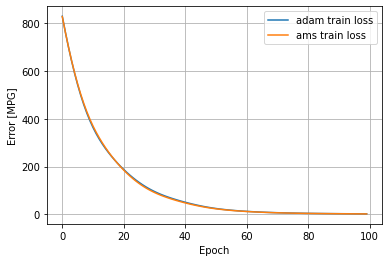

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


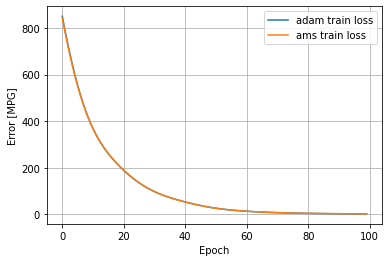

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


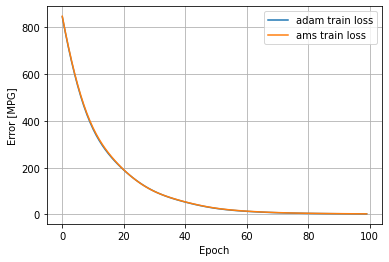

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  1  ------------

Condition Number:  20.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


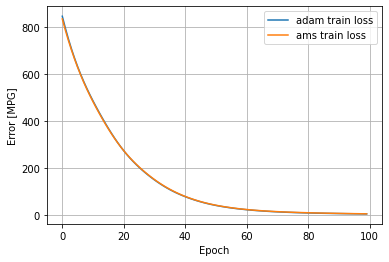

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


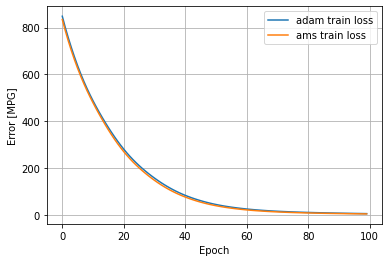

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


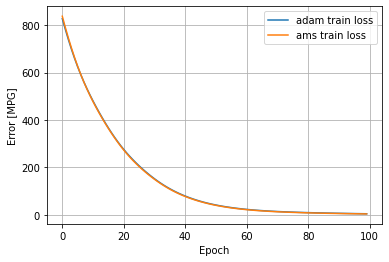

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  2  ------------

Condition Number:  30.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


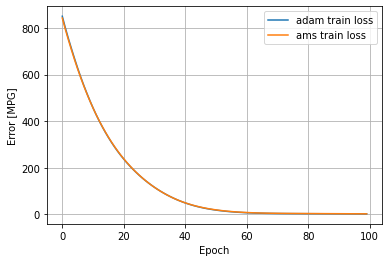

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


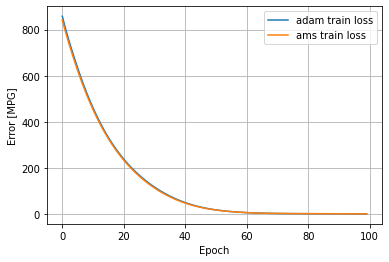

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


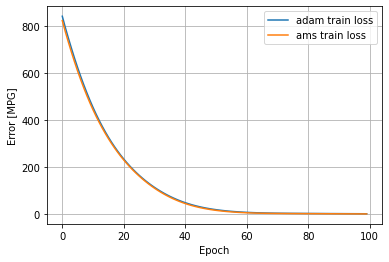

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  3  ------------

Condition Number:  40.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


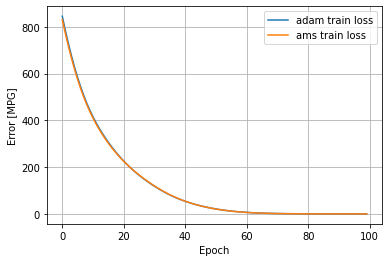

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


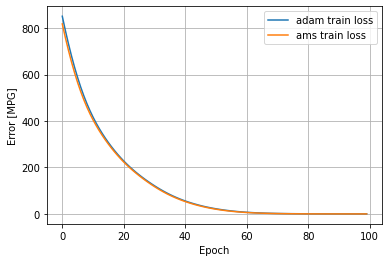

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


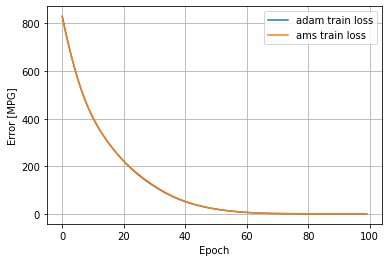

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  4  ------------

Condition Number:  50.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


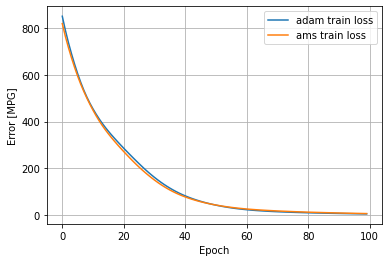

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


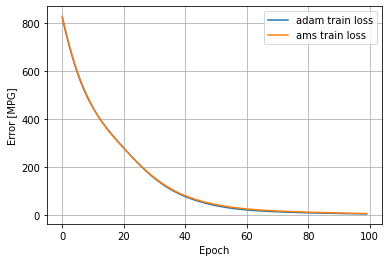

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


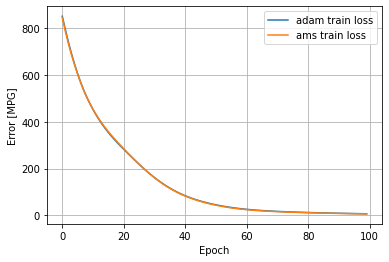

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  5  ------------

Condition Number:  60.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


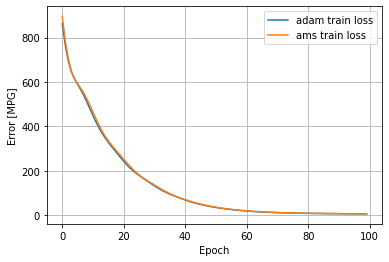

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


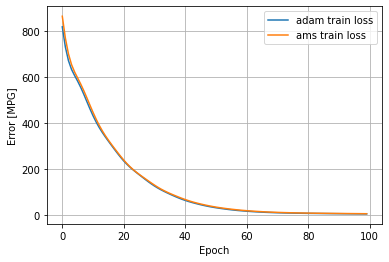

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


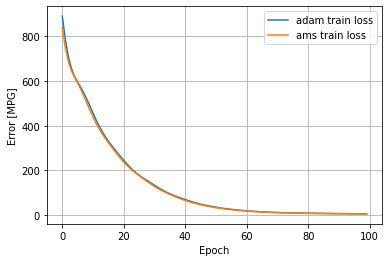

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  6  ------------

Condition Number:  70.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


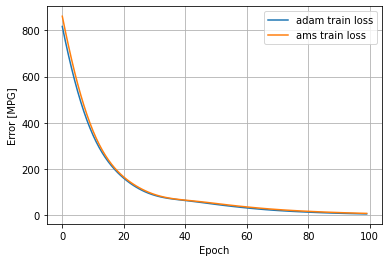

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


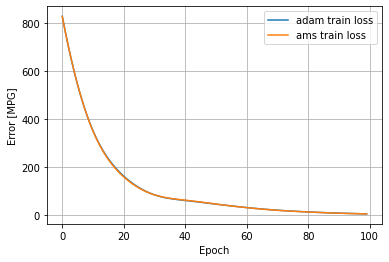

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


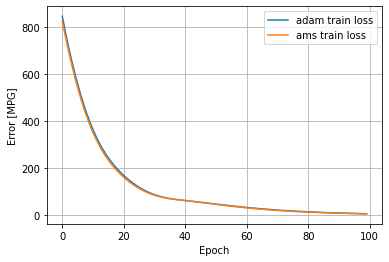

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  7  ------------

Condition Number:  80.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


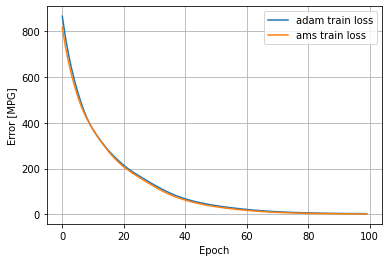

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


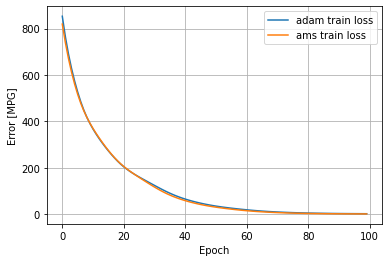

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


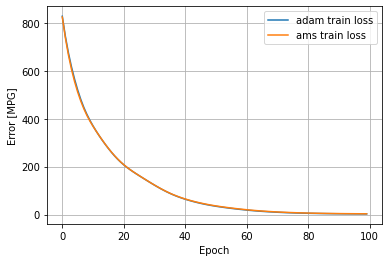

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  8  ------------

Condition Number:  90.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


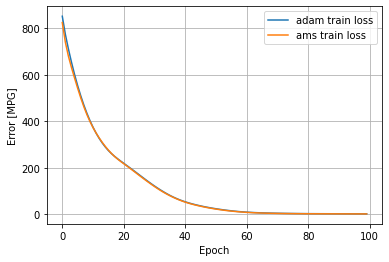

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


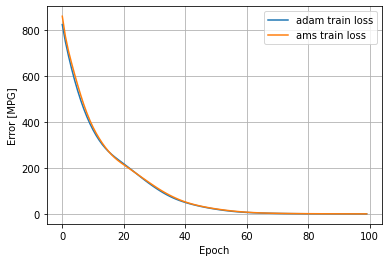

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


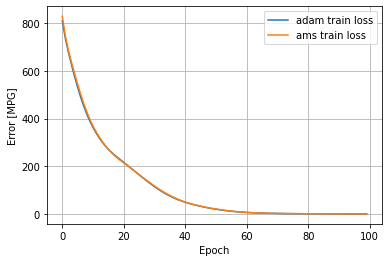

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100


------------ Iter:  9  ------------

Condition Number:  100.0
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


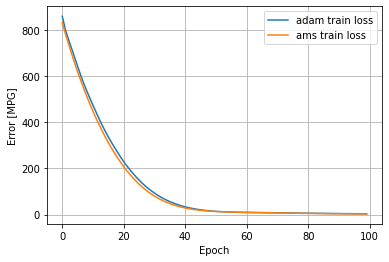

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


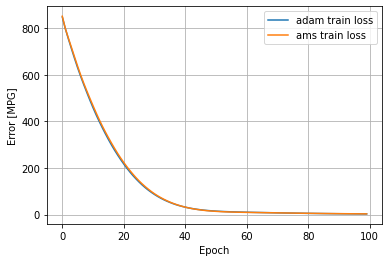

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


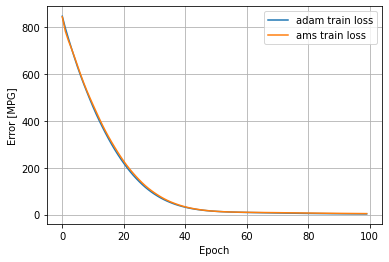

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  100




In [266]:
hist_adam, hist_ams, epoch_adam, epoch_ams = random_diag_mat_2(num_iter=10, avg_iter=3, lr=.5, epochs=100, patience=10, monitor='loss', mat_func=random_matrix_cond)

In [267]:
np.mean(epoch_adam), np.mean(epoch_ams)

(100.0, 100.0)

## Use Different Random Matrix Function that is NOT based on Condtion Number

------------ Iter:  0  ------------

Condition Number:  1.58
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


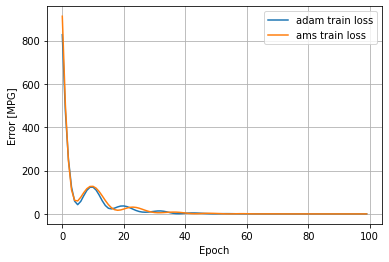

-------
Run:  1
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 100


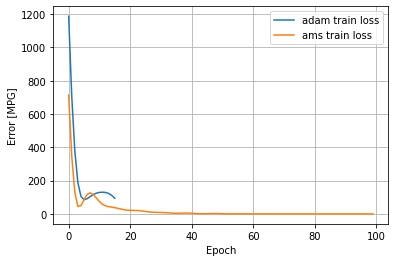

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


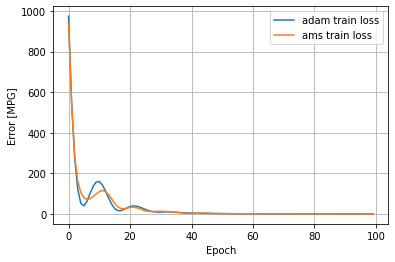

-------

Adam AVG Epochs to Convergence:  72
AMS AVG Epochs to Convergence:  100


------------ Iter:  1  ------------

Condition Number:  1.8
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 15


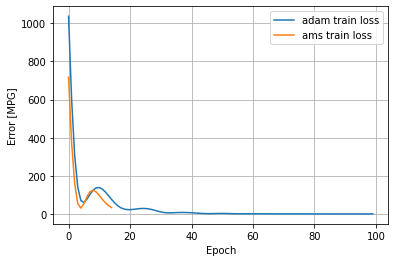

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


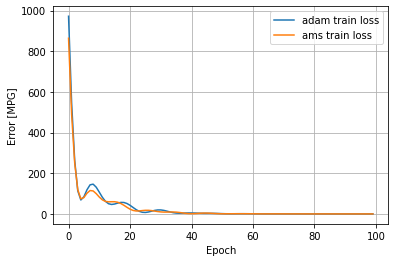

-------
Run:  2
Adam Epochs to Convergence:  17
AMS Epochs to Convergence 15


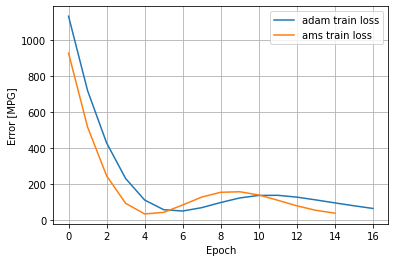

-------

Adam AVG Epochs to Convergence:  73
AMS AVG Epochs to Convergence:  44


------------ Iter:  2  ------------

Condition Number:  1.58
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 15


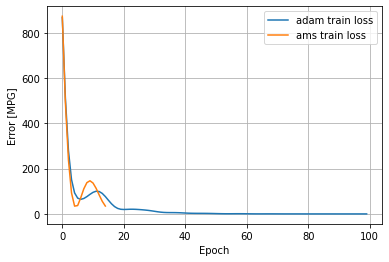

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 47


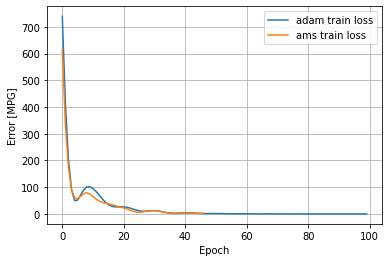

-------
Run:  2
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 100


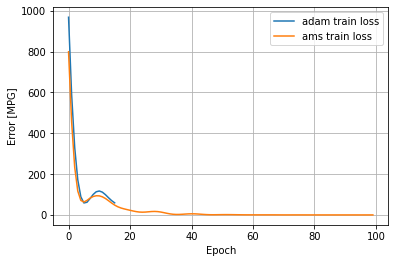

-------

Adam AVG Epochs to Convergence:  72
AMS AVG Epochs to Convergence:  54


------------ Iter:  3  ------------

Condition Number:  1.9
-------
Run:  0
Adam Epochs to Convergence:  68
AMS Epochs to Convergence 100


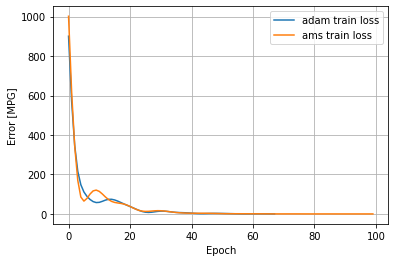

-------
Run:  1
Adam Epochs to Convergence:  35
AMS Epochs to Convergence 19


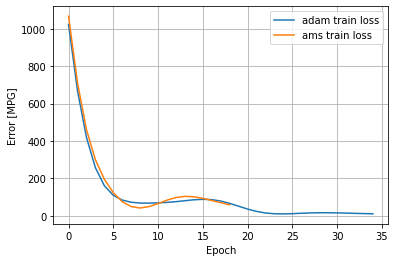

-------
Run:  2
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 18


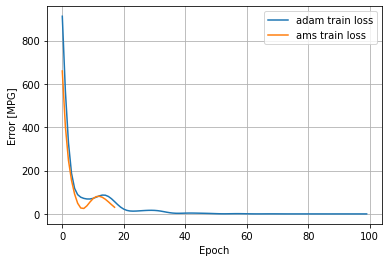

-------

Adam AVG Epochs to Convergence:  68
AMS AVG Epochs to Convergence:  46


------------ Iter:  4  ------------

Condition Number:  1.9
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


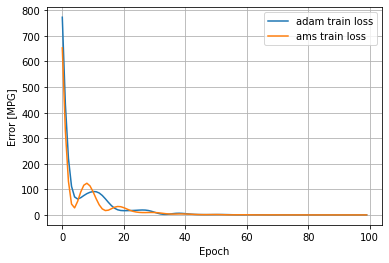

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 87


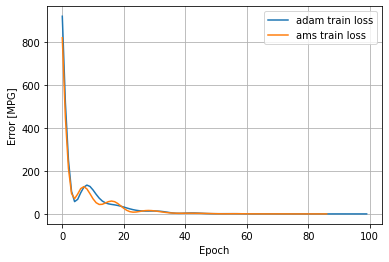

-------
Run:  2
Adam Epochs to Convergence:  98
AMS Epochs to Convergence 30


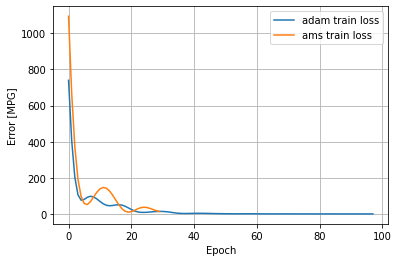

-------

Adam AVG Epochs to Convergence:  100
AMS AVG Epochs to Convergence:  73


------------ Iter:  5  ------------

Condition Number:  1.8
-------
Run:  0
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 15


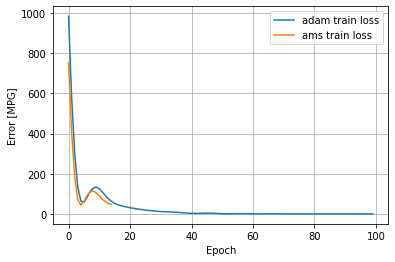

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 16


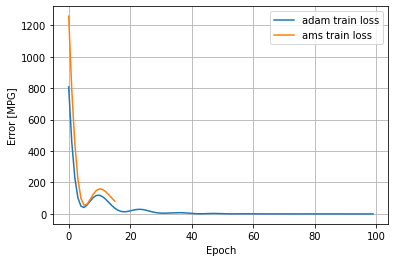

-------
Run:  2
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 100


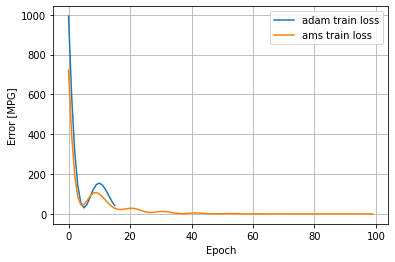

-------

Adam AVG Epochs to Convergence:  72
AMS AVG Epochs to Convergence:  44


------------ Iter:  6  ------------

Condition Number:  1.9
-------
Run:  0
Adam Epochs to Convergence:  17
AMS Epochs to Convergence 70


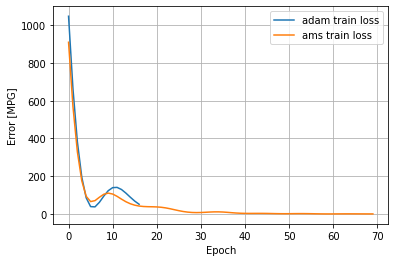

-------
Run:  1
Adam Epochs to Convergence:  17
AMS Epochs to Convergence 17


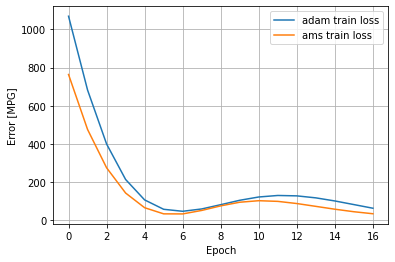

-------
Run:  2
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 38


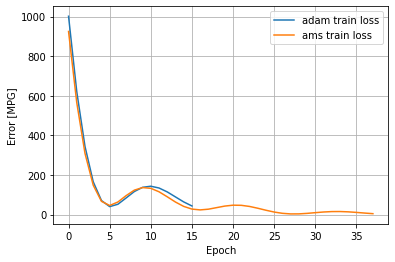

-------

Adam AVG Epochs to Convergence:  17
AMS AVG Epochs to Convergence:  42


------------ Iter:  7  ------------

Condition Number:  1.9
-------
Run:  0
Adam Epochs to Convergence:  70
AMS Epochs to Convergence 100


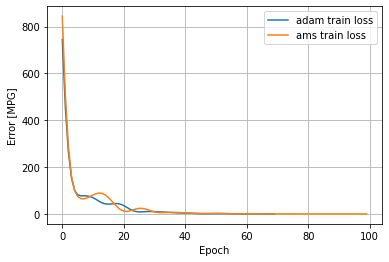

-------
Run:  1
Adam Epochs to Convergence:  100
AMS Epochs to Convergence 100


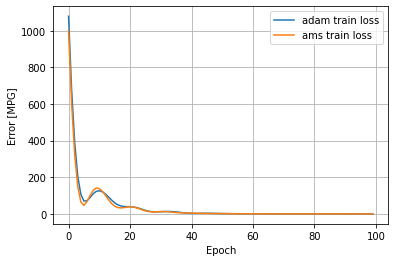

-------
Run:  2
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 100


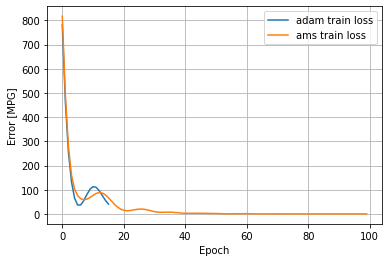

-------

Adam AVG Epochs to Convergence:  62
AMS AVG Epochs to Convergence:  100


------------ Iter:  8  ------------

Condition Number:  1.5
-------
Run:  0
Adam Epochs to Convergence:  17
AMS Epochs to Convergence 17


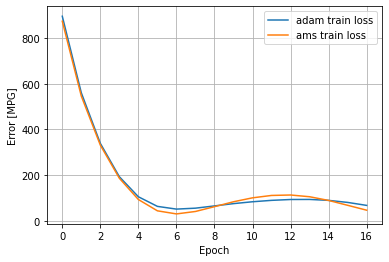

-------
Run:  1
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 18


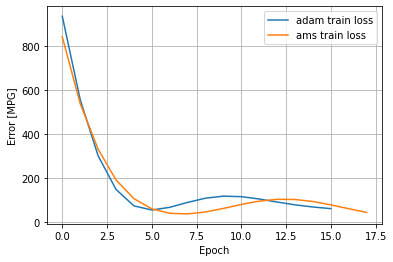

-------
Run:  2
Adam Epochs to Convergence:  16
AMS Epochs to Convergence 17


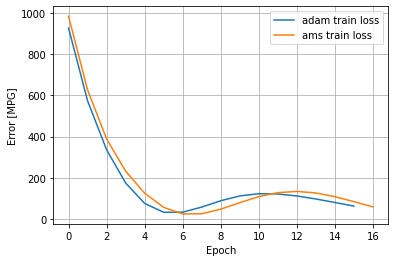

-------

Adam AVG Epochs to Convergence:  17
AMS AVG Epochs to Convergence:  18


------------ Iter:  9  ------------

Condition Number:  1.9
-------
Run:  0
Adam Epochs to Convergence:  98
AMS Epochs to Convergence 73


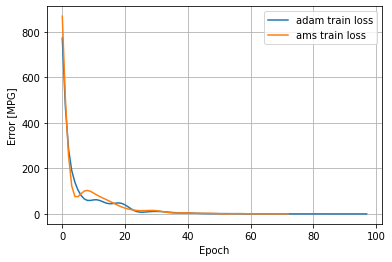

-------
Run:  1
Adam Epochs to Convergence:  17
AMS Epochs to Convergence 17


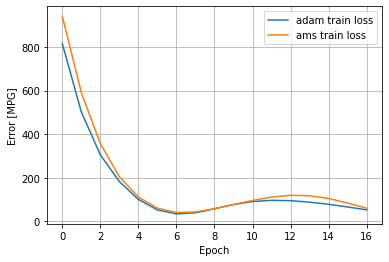

-------
Run:  2
Adam Epochs to Convergence:  18
AMS Epochs to Convergence 100


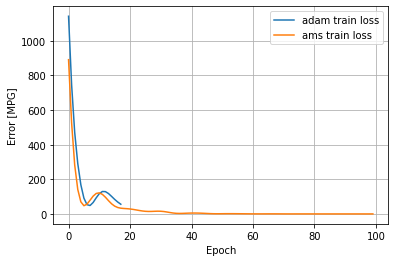

-------

Adam AVG Epochs to Convergence:  45
AMS AVG Epochs to Convergence:  64




In [268]:
hist_adam, hist_ams, epoch_adam, epoch_ams = random_diag_mat_2(num_iter=10, avg_iter=3, lr=.5, epochs=100, patience=10, monitor='loss',mat_func=random_diag)

In [269]:
np.mean(epoch_adam), np.mean(epoch_ams)

(59.8, 58.5)

## Use Jacobi Preconditioned Matrix

In [273]:
def random_diag_mat_3(num_iter, avg_iter, lr, epochs, patience, monitor):
  
  # Number of epochs with no improvement after which training will be stopped
  callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

  # Instantiate running lists
  total_history_adam = []
  total_history_ams = []
  total_epochs_for_convergence_adam = []
  total_epochs_for_convergence_ams = []
  for i in range(num_iter):
    D = conditioned_A
    data_input = tf.convert_to_tensor(D, dtype = tf.float32)

  
    print("------------ Iter: ", i, " ------------")
    print("\nCondition Number: ", round(np.linalg.cond(D),2))

    # Instantiate running lists
    avg_epochs_adam = 0
    avg_epochs_ams = 0
    batch_adam = []
    batch_ams = []
    for j in range(avg_iter):

        # Defining Linear Models for Adama and AMS and compiling
        # linear_model_adam = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
        linear_model_adam = tf.keras.Sequential([layers.Dense(units=1)])
        linear_model_adam.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss='mse')

        # linear_model_ams = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
        linear_model_ams = tf.keras.Sequential([layers.Dense(units=1)])
        linear_model_ams.compile(optimizer=tf.optimizers.Adam(learning_rate=lr, amsgrad=True), loss='mse')
        
        # Run Models
        history_adam = linear_model_adam.fit(
        data_input, train_labels, 
        epochs=epochs,
        verbose=0,
        validation_split = 0.2,
        callbacks=[callback])

        history_ams = linear_model_ams.fit(
        data_input, train_labels, 
        epochs=epochs,
        verbose=0,
        validation_split = 0.2,
        callbacks=[callback])

        # Printing number of epochs for convergence as defined by callback 
        print("-------")
        print("Run: ", j)
        print("Adam Epochs to Convergence: ",  len(history_adam.history['loss']))
        print("AMS Epochs to Convergence", len(history_ams.history['loss']))
        #c

        # Running total of number of epochs until convergence
        avg_epochs_adam += len(history_adam.history['loss'])
        avg_epochs_ams += len(history_ams.history['loss'])

        # Add TensorFlow history objects to running list
        batch_adam.append(history_adam)
        batch_ams.append(history_ams)

        # Plot
        plot_loss_2(history_adam, history_ams)

    total_epochs_for_convergence_adam.append(math.ceil(avg_epochs_adam / avg_iter))
    total_epochs_for_convergence_ams.append(math.ceil(avg_epochs_ams / avg_iter))

    print("-------")
    print("\nAdam AVG Epochs to Convergence: ", math.ceil(avg_epochs_adam / avg_iter))
    print("AMS AVG Epochs to Convergence: ", math.ceil(avg_epochs_ams / avg_iter))
    print("\n")

    total_history_adam.append(batch_adam)
    total_history_ams.append(batch_ams)

  return total_history_adam, total_history_ams, total_epochs_for_convergence_adam, total_epochs_for_convergence_ams

------------ Iter:  0  ------------

Condition Number:  8850.33
-------
Run:  0
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


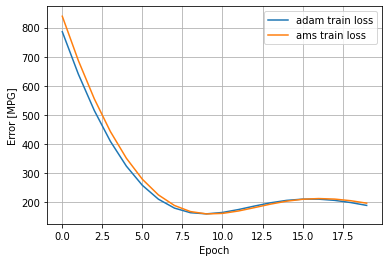

-------
Run:  1
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


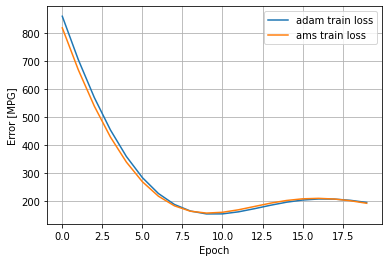

-------
Run:  2
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


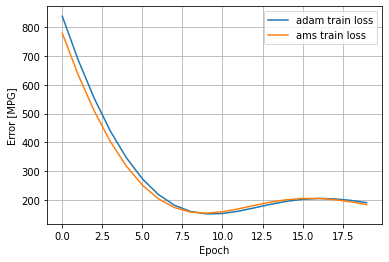

-------
Run:  3
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


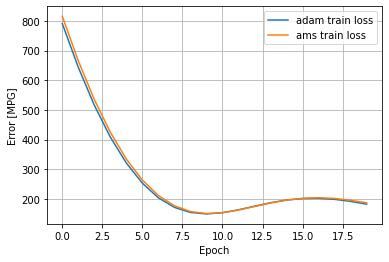

-------
Run:  4
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


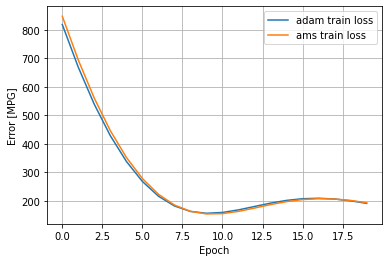

-------
Run:  5
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 20


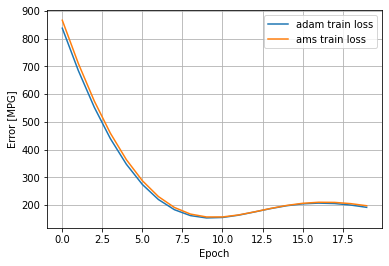

-------
Run:  6
Adam Epochs to Convergence:  21
AMS Epochs to Convergence 20


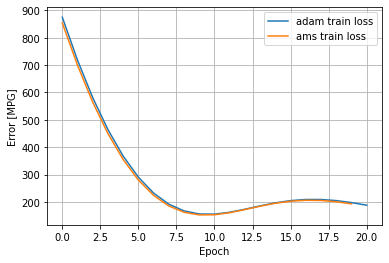

-------
Run:  7
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 21


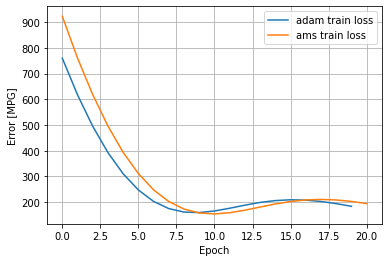

-------
Run:  8
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 21


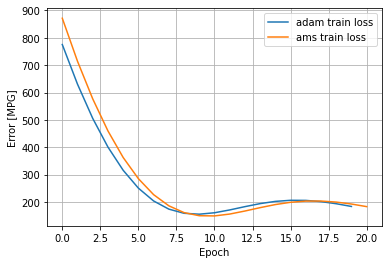

-------
Run:  9
Adam Epochs to Convergence:  20
AMS Epochs to Convergence 21


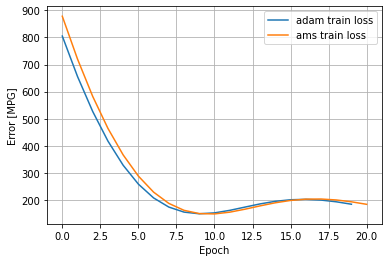

-------

Adam AVG Epochs to Convergence:  21
AMS AVG Epochs to Convergence:  21




In [277]:
hist_adam, hist_ams, epoch_adam, epoch_ams = random_diag_mat_3(num_iter=1, avg_iter=10, lr=.4, epochs=100, patience=10, monitor='loss')

In [278]:
epoch_adam, epoch_ams

([21], [21])